In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ymaeda_tools.dft import dft, exifft_timeshift
from ymaeda_tools.inversion import lstsqinv
from ymaeda_tools.read_dGM import read_dseq1, read_dimseq2, readall_dobs, read_dobs, readall_G, unfold_G 
from ymaeda_tools.read_dGM import readall_mest, read_mest, read_Mseq1, read_G, dcv_to_d, mcv_to_m, Gdbm_to_G

# time step used by YMAEDA_TOOLS
dt = 0.1 
# frequency step size used by YMAEDA_TOOLS
df = 0.002441406 
# frequency half space used by YMAEDA_TOOLS
f = np.arange(0, df*2049, df) 
# frequency full space used by YMAEDA_TOOLS
F = np.arange(0, df*4096, df) 

# base directories
#base_dir = "/Users/ynatsume/jupyter_main/Shinmoedake Data/"
base_dir="/Volumes/TOSHIBA_HDD/Final Year Projects/Shinmoedake Data/kirishima_invert/inversion_results_dump_new/"
parent_dir = "inversion_result_residuals117/t60_p100/x-10900y-121100z1000/"

# target directory
target_dir = "inv_data_dir_supershort_filtered/"

# wanted station
station = "EV.SMN"

In [2]:
def seq1_check(directory_name, xlim = None):
    if "contribution" in directory_name or "green" in directory_name:
        E_suffix = ".E.sac.M.seq1"
        N_suffix = ".N.sac.M.seq1"
        U_suffix = ".U.sac.M.seq1"
    else:
        E_suffix = ".E.sac.seq1"
        N_suffix = ".N.sac.seq1"
        U_suffix = ".U.sac.seq1"
        
    directory_name = base_dir + parent_dir + directory_name + target_dir
    
    E = read_dseq1(directory_name, station + E_suffix)
    N = read_dseq1(directory_name, station + N_suffix)
    U = read_dseq1(directory_name, station + U_suffix)
    
    t = np.arange(0, len(E) * dt, dt)
    
    plt.figure(figsize = (15, 5))
    plt.plot(t, E)
    plt.plot(t, N)
    plt.plot(t, U)
    plt.grid(True)
    if xlim is not None:
        plt.xlim(xlim)
    plt.legend(["E", "N", "U"])
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m/s)")
    plt.show()
    
def imseq2_check(directory_name, xlim = None, ylim = None):
    if "contribution" in directory_name or "green" in directory_name:
        E_suffix = '.E.sac.M.imseq2'
        N_suffix = '.N.sac.M.imseq2'
        U_suffix = '.U.sac.M.imseq2'
    else:
        E_suffix = '.E.sac.imseq2'
        N_suffix = '.N.sac.imseq2'
        U_suffix = '.U.sac.imseq2'
        
    directory_name = base_dir + parent_dir + directory_name + target_dir
    
    f_E, C_E = read_dimseq2(directory_name, station + E_suffix)
    f_N, C_N = read_dimseq2(directory_name, station + N_suffix)
    f_U, C_U = read_dimseq2(directory_name, station + U_suffix)

    plt.figure(figsize = (15, 5))
    plt.plot(f_E, np.abs(C_E))
    plt.plot(f_N, np.abs(C_N))
    plt.plot(f_U, np.abs(C_U))
    plt.grid(True)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.legend(["E", "N", "U"])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Fourier Amplitude")
    plt.show()

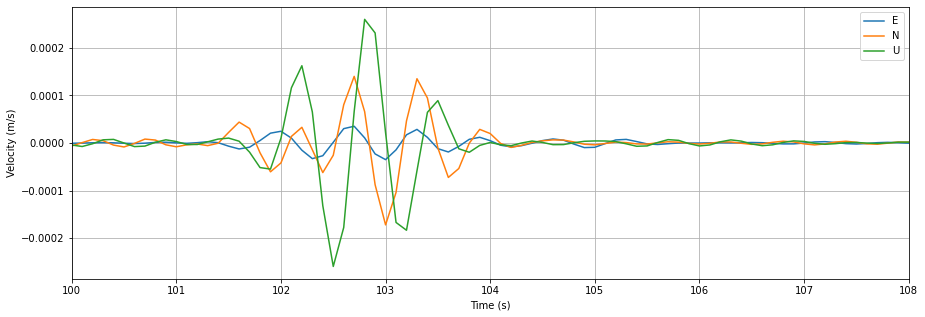

In [3]:
# data directories for contribution traces .seq1 files check
seq1_check("contribution/", [100, 108])

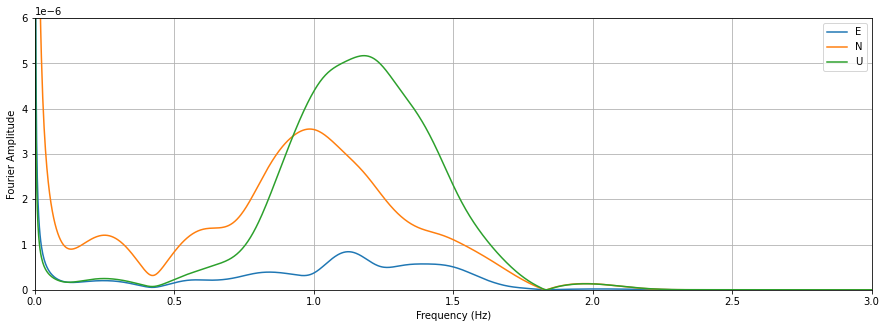

In [4]:
# target directories for contribution Fourier spectra .imseq2 files check
imseq2_check("contribution_spectrum/", [0, 3], [0, 6e-6])

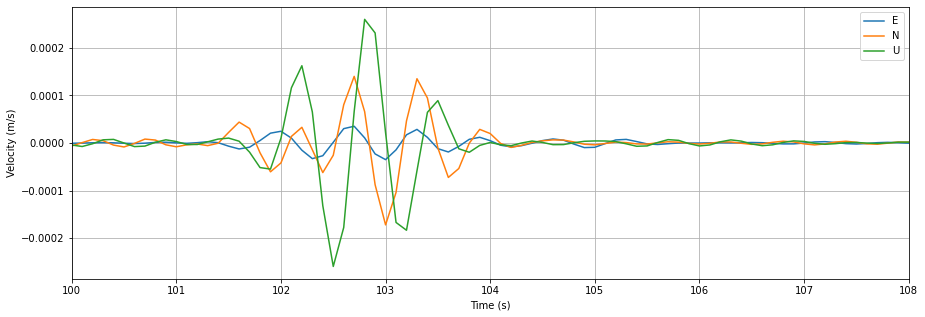

In [5]:
# data directories for seismogram traces .seq1 files check
seq1_check("data_syn/", [100, 108])

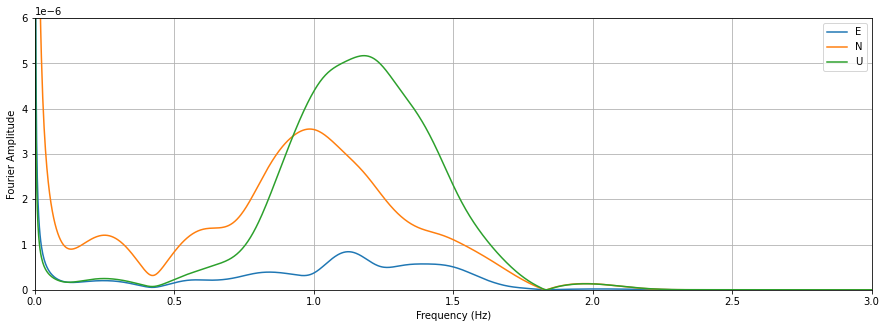

In [6]:
# target directories for seismogram Fourier spectra .imseq2 files check
imseq2_check("data_syn_spectrum/", [0, 3], [0, 6e-6])

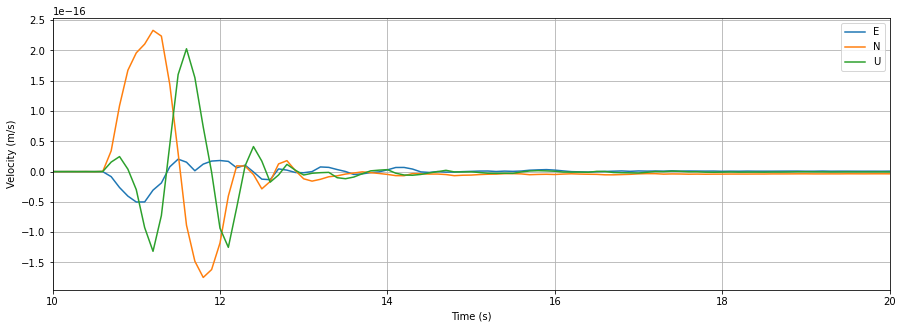

In [7]:
# Check Green's functions time series
seq1_check("green/", [10, 20])

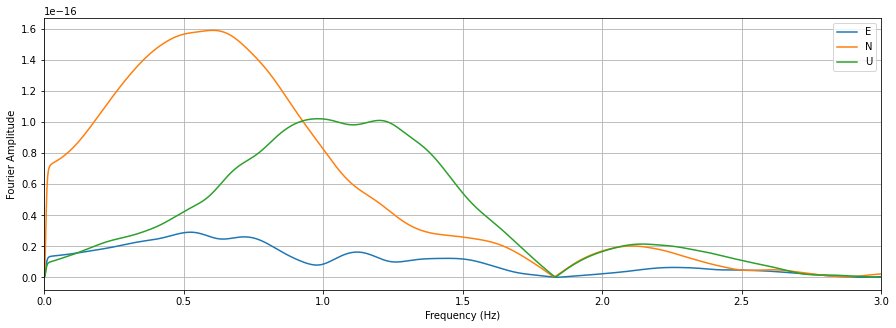

In [8]:
# Check Green's functions Fourier spectrum
imseq2_check("green_spectrum/", [0, 3])

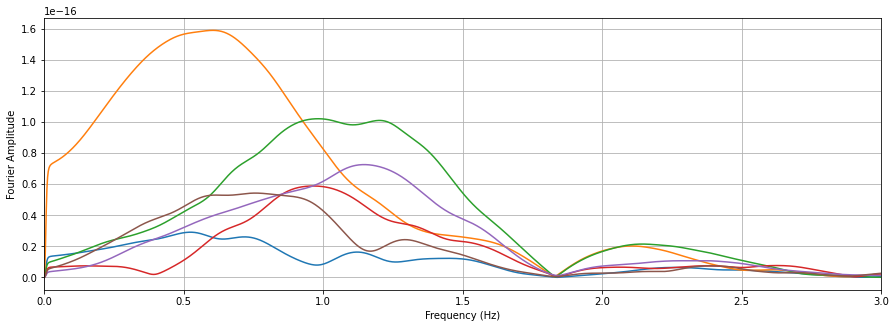

In [9]:
# Inversion use G.bdm (Green's functions in Fourier space) check.
# These are the actual Green's functions files used during Linear Inversion!

# Note that the spectrum is the same as that in green_spectrum/!

G = readall_G(base_dir + parent_dir)

g_0 = unfold_G(G, 0)
g_1 = unfold_G(G, 1)
g_2 = unfold_G(G, 2)
g_3 = unfold_G(G, 3)
g_4 = unfold_G(G, 4)
g_5 = unfold_G(G, 5)

plt.figure(figsize = (15, 5))
plt.plot(f, np.abs(g_0))
plt.plot(f, np.abs(g_1))
plt.plot(f, np.abs(g_2))
plt.plot(f, np.abs(g_3))
plt.plot(f, np.abs(g_4))
plt.plot(f, np.abs(g_5))
plt.grid(True)
plt.xlim([0, 3])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Fourier Amplitude")
plt.show()

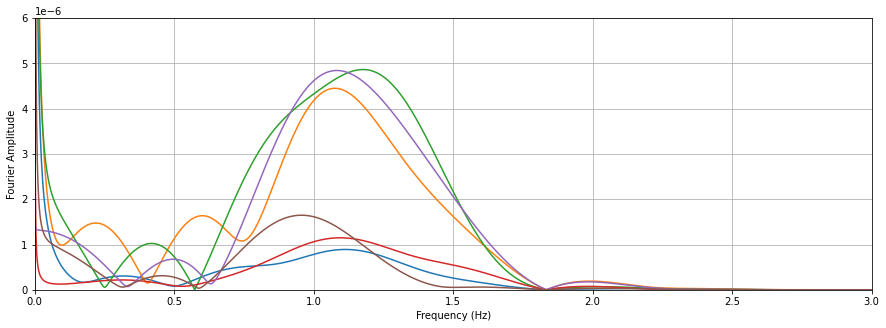

In [10]:
# d_obs.cv frequency domain (used for linear inversion) files check
# These are the actual observed seismogram files used during Linear Inversion!

# The values in d_obs.cv do not match those in contribution or data_syn directly as several modifications
# have been applied to the original observed traces:
# 1. remove initial offset
# 2. set time window of taper
# 3. multiply taper
# 4. modify the time window and sampling rate to those used in the Green's functions
# 5. zero pad and conduct FFT
# 6. multiply the Fourier spectrum of the source time function
# 7. correct the spectrum of the envelope
# For the original C code, refer to make_data_seq.h

dobs_dir = base_dir + parent_dir

dobs_0 = readall_dobs(dobs_dir, ROW = 0)
dobs_1 = readall_dobs(dobs_dir, ROW = 1)
dobs_2 = readall_dobs(dobs_dir, ROW = 2)
dobs_3 = readall_dobs(dobs_dir, ROW = 3)
dobs_4 = readall_dobs(dobs_dir, ROW = 4)
dobs_5 = readall_dobs(dobs_dir, ROW = 5)

plt.figure(figsize = (15, 5))
plt.plot(f, np.abs(dobs_0))
plt.plot(f, np.abs(dobs_1))
plt.plot(f, np.abs(dobs_2))
plt.plot(f, np.abs(dobs_3))
plt.plot(f, np.abs(dobs_4))
plt.plot(f, np.abs(dobs_5))
plt.grid(True)
plt.ylim([0, 6e-6])
plt.xlim([0, 3])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Fourier Amplitude")
plt.show()

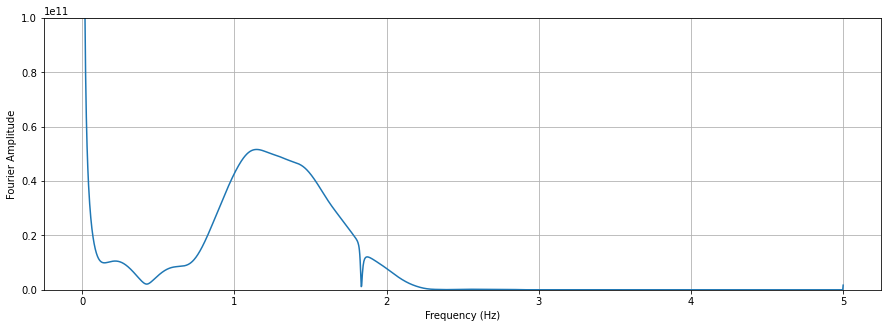

In [11]:
# m_est.cv frequency domain (used for linear inversion) files check
# These are the actual estimated m obtained during Linear Inversion!
# This should be in half-width Fourier space!

m_est_dir = base_dir + parent_dir

m_est = readall_mest(m_est_dir)

plt.figure(figsize = (15, 5))
plt.plot(f, np.sqrt(m_est[:, 0]**2 + m_est[:, 1]**2))
plt.grid(True)
plt.ylim([0, 1e11])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Fourier Amplitude")
plt.show()

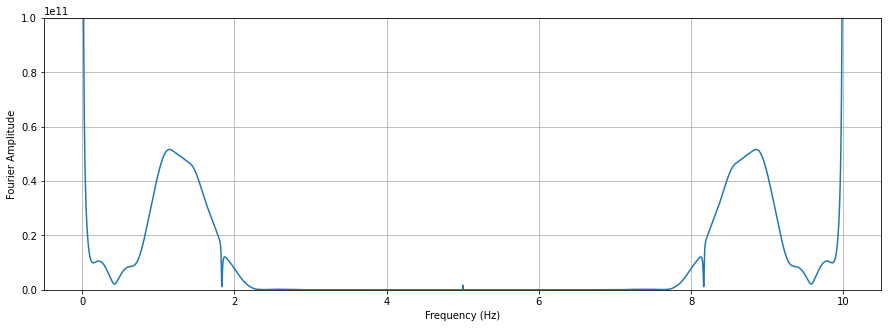

In [12]:
# model_spectrum check: this should be the full width Fourier space of the data in m_est.cv!
directory_name = base_dir + parent_dir + "model_spectrum/"
f_m, C_m = read_dimseq2(directory_name, "M.imseq2")

plt.figure(figsize = (15, 5))
plt.plot(f_m, np.abs(C_m))
plt.grid(True)
plt.ylim([0, 1e11])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Fourier Amplitude")
plt.show()

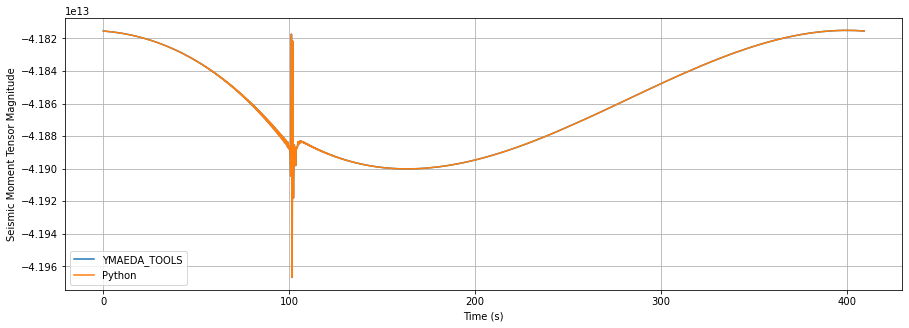

In [13]:
# model time series check: this should be the ifft of the m_est.cv data!
directory_name = base_dir + parent_dir 

M = read_Mseq1(directory_name)

t = np.arange(0, len(M) * dt, dt)

M_est = np.real(exifft_timeshift(m_est, 1000) / dt)

plt.figure(figsize = (15, 5))
plt.plot(t, M)
plt.plot(t, M_est)
plt.legend(["YMAEDA_TOOLS", "Python"])
plt.grid(True)
plt.xlabel("Time (s)")
plt.ylabel("Seismic Moment Tensor Magnitude")
plt.show()

In [14]:
# Check the contents of the individual files associated directly with the inversion process itself:

file_index = 1234

# contents of a single d_obs.cv file:
d = read_dobs(base_dir + parent_dir, file_index)
dd = dcv_to_d(d)

# contents of a single G.bdm file:
G = read_G(base_dir + parent_dir, file_index)
GG = Gdbm_to_G(G)

# contents of a single m_est.cv file:
m = read_mest(base_dir + parent_dir, file_index)
mm = mcv_to_m(m)

def least_squares(G, d):   
    m = np.dot(np.linalg.inv(np.dot(np.conj(G.T), G)), np.conj(G.T))
    m = np.dot(m, d)
    return m

print("d: {}, G: {}, m: {}".format(d.shape, G.shape, m.shape))
print("dd: {}, GG: {}, mm: {}".format(dd.shape, GG.shape, mm.shape))

print("Calculated: ", np.array(lstsqinv(G, d)).astype(int))
print("Loaded data:", m.astype(int))
print("Cplx. calc.:", least_squares(GG, dd))

# Comments:
# Observed seismograms: 2 stations, 3 directions, 2 parts real + imag
# Estimated moment tensor: 1 element, 2 parts real + imag
# Therefore: 
# d has 2 * 3 * 2 = 12 elements
# m has 1 * 2 = 2 elements
# G has 12 * 2 =  24 elements

d: (12,), G: (12, 2), m: (2,)
dd: (6,), GG: (6, 1), mm: (1,)
Calculated:  [-9753019 14237922]
Loaded data: [-9753019 14237920]
Cplx. calc.: [-9753019.63744872+14237922.76443982j]
